In [26]:
try:
    #tensorflow_version only exists in colab
    %tensorflow_version 2.x
except Exception:
    pass

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda, Flatten
from tensorflow.keras.datasets import  fashion_mnist
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.utils.vis_utils import plot_model
from keras import backend as k

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFont, ImageDraw
import random

In [3]:
!python --version

Python 3.6.9


In [4]:
def creat_pairs(X,digit_indices):
    '''
    Positive and negative pairs creation, Alternate between positive nad negative pairs.
    '''
    pairs = []
    labels = []

    n = min([len(digit_indices[d]) for d in range(10)])-1

    for d in range(10):
        for i in range(n):

            Z1, Z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[X[Z1], X[Z2]]]
            inc = random.randrange(1,10)
            dn=(d+inc)%10

            Z1, Z2= digit_indices[d][i], digit_indices[dn][i]

            pairs += [[X[Z1], X[Z2]]]

            labels += [1, 0]

    return np.array(pairs), np.array(labels)

In [5]:
def creat_pairs_on_set(images, labels):

    digit_indices = [np.where(labels==i)[0] for i in range(10)]

    pairs, y =creat_pairs(images, digit_indices)
    y=y.astype('float32')

    return pairs, y

In [6]:
(train_images, trian_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images/255
test_images = test_images/255

tr_pairs, tr_y = creat_pairs_on_set(train_images,trian_labels)
ts_pairs, ts_y = creat_pairs_on_set(test_images,test_labels)


In [7]:
tr_pairs.shape

(119980, 2, 28, 28)

In [8]:
tr_y.shape

(119980,)

In [9]:
def Image_show(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

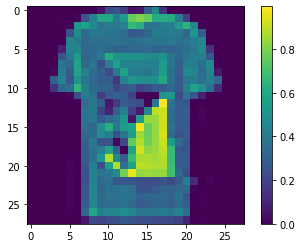

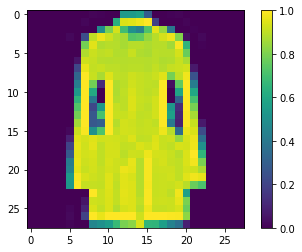

0.0


In [10]:
this_pair =101

Image_show(tr_pairs[this_pair][0])
Image_show(tr_pairs[this_pair][1])

print(tr_y[this_pair])

In [11]:
def initialize_base_network():
    input = Input(shape=(28,28,),name='base_input')
    x=Flatten(name='Flatten_input')(input)
    x=Dense(128,activation='relu',name='first_base_dense')(x)
    x=Dropout(0.1,name='First_Dropout')(x)
    x=Dense(128,activation='relu',name='Second_base_dense')(x)
    x=Dropout(0.1,name='Second_Dropout')(x)
    x=Dense(128,activation='relu',name='Third_base_dense')(x)
    return Model(inputs=input,outputs=x)

In [12]:
def Euclidean_distance(vects):
    x,y=vects
    Sum_Squared=k.sum(k.square(x-y),axis=1, keepdims=True)
    return k.sqrt(k.maximum(Sum_Squared, k.epsilon()))

In [13]:
def Eucl_dist_output_shape(shapes):
    shape1,shape2=shapes
    
    return (shape1[0], 1)

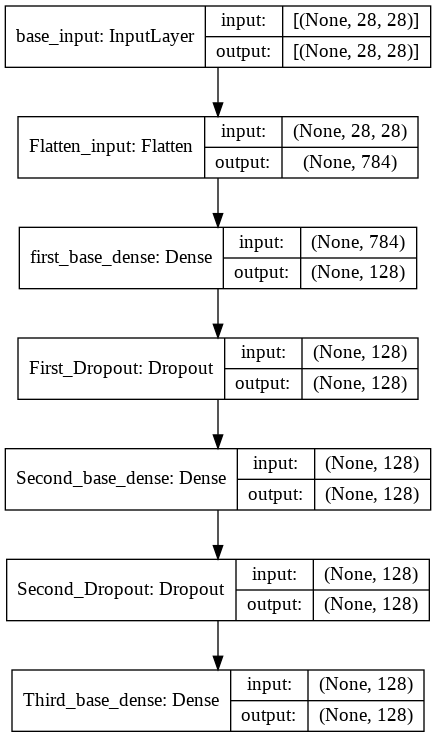

In [14]:
base_network= initialize_base_network()
plot_model(base_network,show_shapes=True,show_layer_names=True,to_file='Base_model.png')

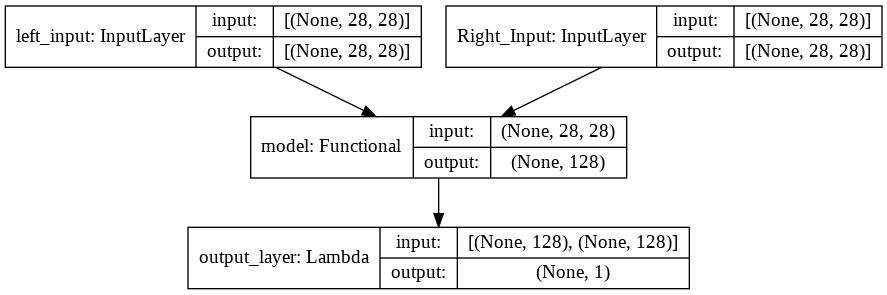

In [15]:
input_a = Input(shape=(28,28,),name='left_input')
vect_output_a=base_network(input_a)
input_b = Input(shape=(28,28,),name='Right_Input')
vect_output_b = base_network(input_b)
output = Lambda(Euclidean_distance,name='output_layer',output_shape=Eucl_dist_output_shape)([vect_output_a, vect_output_b])

model = Model(inputs=[input_a,input_b],outputs=output)

#plot model graph

plot_model(model,show_shapes=True,show_layer_names=True,to_file='outer_model.png')

In [16]:
vect_output_a.shape[0]

In [17]:
def Contrastive_Loss_With_Margin(margin):
    def Contrastive_Loss(y_true,y_pred):
        Squared_pred=k.square(y_pred)
        margin_squared = k.square(k.maximum(margin-y_pred,0))
        return k.mean(y_true*Squared_pred+(1-y_true)*margin_squared)
    return Contrastive_Loss

In [18]:
rms = RMSprop()

model.compile(loss=Contrastive_Loss_With_Margin(margin=1),optimizer=rms)

history = model.fit([tr_pairs[:,0],tr_pairs[:,1]],tr_y,
                    epochs=20, batch_size=128,
                    validation_data=([ts_pairs[:,0],ts_pairs[:,1]],ts_y
                                     ))

Epoch 1/20
938/938 [==============================] - 5s 4ms/step - loss: 0.1513 - val_loss: 0.0865
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0830 - val_loss: 0.0773
Epoch 3/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0727 - val_loss: 0.0739
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0665 - val_loss: 0.0681
Epoch 5/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0639 - val_loss: 0.0674
Epoch 6/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0608 - val_loss: 0.0719
Epoch 7/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0608 - val_loss: 0.0681
Epoch 8/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0592 - val_loss: 0.0673
Epoch 9/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0580 - val_loss: 0.0677
Epoch 10/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0564 - val_loss: 0.0641

In [19]:
loss= model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]],y=ts_y)

625/625 [==============================] - 1s 2ms/step - loss: 0.0630


In [20]:
def comput_accuracy(y_true, y_pred):
    pred = y_pred.ravel() > 0.5
    return np.mean(pred==y_true)

In [21]:
y_pred_train = model.predict([tr_pairs[:,0],tr_pairs[:,1]])
train_accuracy = comput_accuracy(tr_y,y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0],ts_pairs[:,1]])
test_accuracy = comput_accuracy(ts_y,y_pred_test)

print(f'Loss= {loss}, Train Accuracy = {train_accuracy}, Test Accuracy= {test_accuracy}')

Loss= 0.06297110766172409, Train Accuracy = 0.06006834472412069, Test Accuracy= 0.08613613613613613


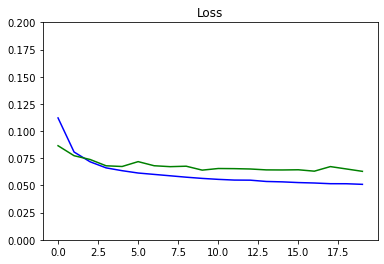

In [22]:
def plot_metrics(metric_name,title,ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue', label=metric_name)
    plt.plot(history.history['val_'+metric_name],color='green',label='val_'+metric_name)
    plt.show()


plot_metrics(metric_name='loss',title='Loss',ylim=0.2)

In [23]:
def visualize_images():
    #matplotlib config
    plt.rc('image',cmap='gray_r')
    plt.rc('grid',linewidth=0)
    plt.rc('xtick',top=False, bottom=False, labelsize='large')
    plt.rc('ytick',left=False, right=False, labelsize='large')
    plt.rc('axes',facecolor='F8F8F8',titlesize='large',edgecolor='white')
    plt.rc('text',color='a8151a')
    plt.rc('figure',facecolor='F0F0F0')

In [24]:
#Utility to display a a row of digits with their predictions

def display_images(left,right,predictions, labels, title, n):

    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    plt.grid(None)

    left=np.reshape(left,[n,28,28])
    left=np.swapaxes(left,0,1)
    left=np.reshape(left,[28,28*n])
    plt.imshow(left)

    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)

    for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] >0.5: t.set_color('red')

    plt.grid(None)
    right=np.reshape(right,[n,28,28])
    right=np.swapaxes(right,0,1)
    right=np.reshape(right,[28,28*n])
    plt.imshow(right)


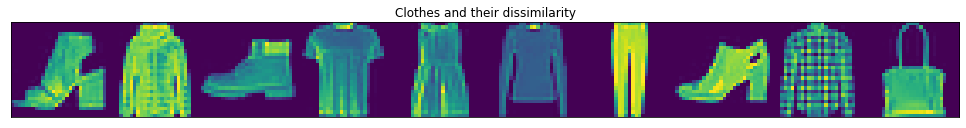

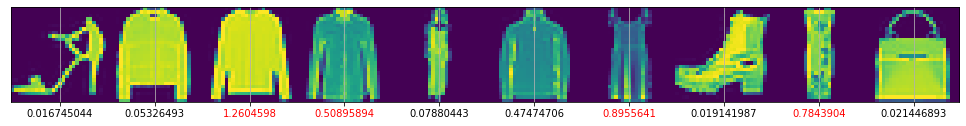

In [28]:
#visualize_images()
y_pred_train=np.squeeze(y_pred_train)
indecis= np.random.choice(len(y_pred_train),size=10)
display_images(tr_pairs[:,0][indecis],tr_pairs[:,1][indecis],y_pred_train[indecis],tr_y[indecis],'Clothes and their dissimilarity',n=10)